<a href="https://colab.research.google.com/github/rajanaids-hub/Reinforcement_Learning_Lab/blob/main/MDP_%26_Value_Iteration_Exp4_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚀 Building the Stochastic MDP...
🧮 Running Value Iteration to solve Bellman Equations...
✅ Value Iteration converged in 16 sweeps.
📊 Rendering optimal policy map...


/tmp/ipython-input-4095827448.py:181: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4095827448.py:181: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


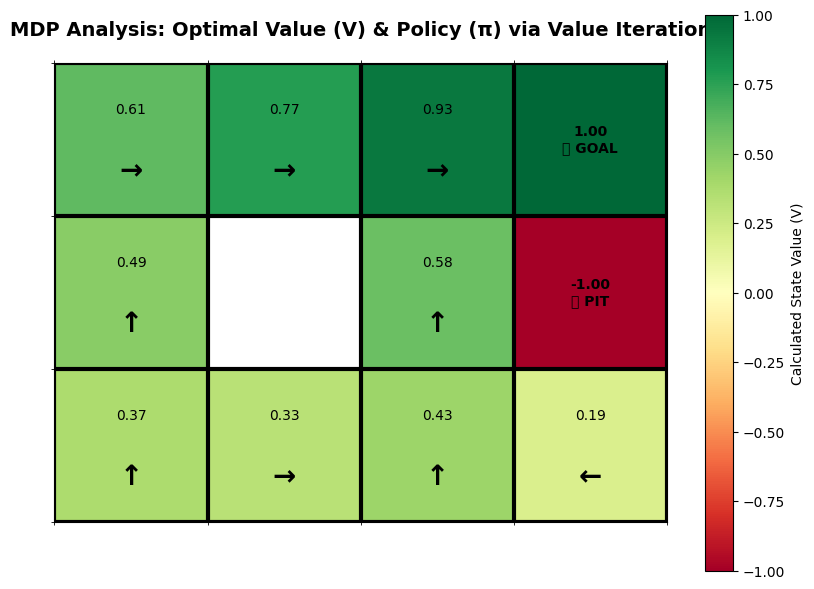

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# =====================================================================
# 🎓 STUDENT EXPERIMENT SETTINGS: MDP ANALYSIS 🎓
# =====================================================================
# The Discount Factor determines how much the agent cares about the future.
# Try changing this to 0.5 or 0.1 to see how the agent becomes "short-sighted"!
GAMMA = 0.9

# How slippery is the floor?
# 1.0 = perfect control.
# 0.8 = 80% chance to go the right way, 10% chance to slip left, 10% right.
INTENDED_PROB = 0.8
# =====================================================================

class StochasticGridMDP:
    """
    A classic 3x4 grid world used in AI textbooks (like Russell & Norvig).
    This explicitly defines the entire Markov Decision Process (MDP).
    """
    def __init__(self, intended_prob=INTENDED_PROB):
        self.rows = 3
        self.cols = 4
        self.states = [(r, c) for r in range(self.rows) for c in range(self.cols)]

        # 0: UP, 1: RIGHT, 2: DOWN, 3: LEFT
        self.actions = [0, 1, 2, 3]
        self.action_deltas = {0: (-1, 0), 1: (0, 1), 2: (1, 0), 3: (0, -1)}

        self.goal_state = (0, 3)
        self.pit_state = (1, 3)
        self.wall_state = (1, 1) # An obstacle we cannot enter

        self.intended_prob = intended_prob
        self.slip_prob = (1.0 - intended_prob) / 2.0

    def is_terminal(self, state):
        return state in [self.goal_state, self.pit_state]

    def _get_next_pos(self, state, action):
        """Calculates where the agent ends up, handling wall bounces."""
        r, c = state
        dr, dc = self.action_deltas[action]
        next_r, next_c = r + dr, c + dc

        # If it hits the outer boundary or the inner wall, it bounces back
        if next_r < 0 or next_r >= self.rows or next_c < 0 or next_c >= self.cols or (next_r, next_c) == self.wall_state:
            return state
        return (next_r, next_c)

    def get_transitions(self, state, action):
        """
        The core of the MDP: P(s' | s, a) and R(s, a, s').
        Returns a list of tuples: (probability, next_state, reward)
        """
        if self.is_terminal(state):
            return [(1.0, state, 0.0)] # If the game is over, you stay there and get nothing

        transitions = {}

        # 1. Intended movement (e.g., trying to go UP)
        intended_next = self._get_next_pos(state, action)
        transitions[intended_next] = transitions.get(intended_next, 0) + self.intended_prob

        # 2. Slipping orthogonal left (e.g., slipping LEFT while trying to go UP)
        slip_left_action = (action - 1) % 4
        slip_left_next = self._get_next_pos(state, slip_left_action)
        transitions[slip_left_next] = transitions.get(slip_left_next, 0) + self.slip_prob

        # 3. Slipping orthogonal right (e.g., slipping RIGHT while trying to go UP)
        slip_right_action = (action + 1) % 4
        slip_right_next = self._get_next_pos(state, slip_right_action)
        transitions[slip_right_next] = transitions.get(slip_right_next, 0) + self.slip_prob

        # Compile the final transition probabilities and rewards
        result = []
        for next_s, prob in transitions.items():
            if next_s == self.goal_state:
                reward = 1.0    # 🟢 Big reward for goal
            elif next_s == self.pit_state:
                reward = -1.0   # 🔴 Big penalty for pit
            else:
                reward = -0.04  # ⏳ Small penalty for living (encourages speed)
            result.append((prob, next_s, reward))

        return result

# =====================================================================
# 🧠 DYNAMIC PROGRAMMING: VALUE ITERATION
# =====================================================================
def value_iteration(mdp, gamma=GAMMA, theta=1e-4):
    """
    Calculates the exact theoretical Value (V) for every state.
    It stops when the updates are smaller than the threshold (theta).
    """
    V = {s: 0.0 for s in mdp.states}
    policy = {s: 0 for s in mdp.states}

    iteration = 0
    while True:
        delta = 0
        new_V = V.copy()

        for s in mdp.states:
            if s == mdp.wall_state or mdp.is_terminal(s):
                continue

            # Bellman Optimality Equation: Look at all actions and pick the best one
            action_values = []
            for a in mdp.actions:
                # Expected value = Sum of [ Probability * (Reward + Gamma * Value(Next State)) ]
                expected_value = sum(
                    prob * (reward + gamma * V[next_s])
                    for prob, next_s, reward in mdp.get_transitions(s, a)
                )
                action_values.append(expected_value)

            best_value = max(action_values)
            new_V[s] = best_value
            policy[s] = np.argmax(action_values) # Save the best action

            delta = max(delta, abs(best_value - V[s]))

        V = new_V
        iteration += 1

        if delta < theta:
            print(f"✅ Value Iteration converged in {iteration} sweeps.")
            break

    # Assign specific values to terminal states for visualization
    V[mdp.goal_state] = 1.0
    V[mdp.pit_state] = -1.0
    return V, policy

# =====================================================================
# 📉 VISUALIZATION
# =====================================================================
def plot_mdp_analysis(mdp, V, policy):
    """Draws a heatmap of the State Values and overlays the Optimal Policy arrows."""
    fig, ax = plt.subplots(figsize=(8, 6))

    # Create a 2D array for the heatmap
    v_grid = np.zeros((mdp.rows, mdp.cols))
    for r in range(mdp.rows):
        for c in range(mdp.cols):
            v_grid[r, c] = V[(r, c)]

    # Force the wall to be completely blank/black
    v_grid[mdp.wall_state[0], mdp.wall_state[1]] = np.nan

    cax = ax.matshow(v_grid, cmap='RdYlGn', vmin=-1, vmax=1)
    fig.colorbar(cax, label="Calculated State Value (V)")

    arrows = {0: '↑', 1: '→', 2: '↓', 3: '←'}

    for r in range(mdp.rows):
        for c in range(mdp.cols):
            s = (r, c)

            if s == mdp.wall_state:
                ax.text(c, r, "WALL", va='center', ha='center', color='white', weight='bold')
            elif s == mdp.goal_state:
                ax.text(c, r, f"{V[s]:.2f}\n🟢 GOAL", va='center', ha='center', color='black', weight='bold')
            elif s == mdp.pit_state:
                ax.text(c, r, f"{V[s]:.2f}\n🔴 PIT", va='center', ha='center', color='black', weight='bold')
            else:
                # Print the calculated Value score
                ax.text(c, r - 0.2, f"{V[s]:.2f}", va='center', ha='center', color='black')
                # Print the Policy Arrow
                best_act = policy[s]
                ax.text(c, r + 0.2, arrows[best_act], va='center', ha='center', color='black', fontsize=20, weight='bold')

    ax.set_xticks(np.arange(-0.5, mdp.cols, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, mdp.rows, 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=3)
    ax.set_xticks([]); ax.set_yticks([])

    plt.title("MDP Analysis: Optimal Value (V) & Policy (π) via Value Iteration", pad=20, fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    print("🚀 Building the Stochastic MDP...")
    mdp = StochasticGridMDP()

    print("🧮 Running Value Iteration to solve Bellman Equations...")
    V, policy = value_iteration(mdp)

    print("📊 Rendering optimal policy map...")
    plot_mdp_analysis(mdp, V, policy)